In [1]:
import gym
from tqdm import tqdm
import numpy as np
from typing import List, Dict
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

In [2]:
env = gym.make("Taxi-v3").env

env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [3]:
env.reset() # reset environment to a new, random state
env.render()

print("Przestrzeń akcji: {}".format(env.action_space.n))
print("Przestrzeń stanów: {}".format(env.observation_space.n))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Przestrzeń akcji: 6
Przestrzeń stanów: 500


In [4]:
# (row, column, passenger index, destination index)
state = env.encode(1, 2, 2, 0)
print("Stan:", state)

env.s = state
env.render(mode='human')
# print(env.render(mode='ansi'))

Stan: 148
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [5]:
env.P[16] # (prob, next_state, reward, done)

{0: [(1.0, 116, -1, False)],
 1: [(1.0, 16, -1, False)],
 2: [(1.0, 36, -1, False)],
 3: [(1.0, 16, -1, False)],
 4: [(1.0, 16, -10, False)],
 5: [(1.0, 0, 20, True)]}

In [6]:
# Główna pętla interakcji agenta ze środowiskiem (bez treningu)
# agent = Agent(env)
# state = env.reset()

# done = False
# while not done:
#     action = agent.act(state)
#     state, reward, done, info = env.step(action)

    # zapisz nagrody i inne informacje o stanie

In [7]:
class Agent:
    def __init__(self, environment: gym.Env) -> None:
        self.env = environment
    
    def learn(self, epochs: int) -> None:
        pass
    
    def act(self, state: int) -> int:
        pass

    def evaluate(self, episodes: int) -> None:
        total_epochs, total_penalties = [], []
        for _ in tqdm(range(episodes)):
            epochs, penalties = 0, 0
            
            state = self.env.reset()

            done = False
            while not done:
                action = self.act(state)

                state, reward, done, info = self.env.step(action)

                if reward == -10:
                    penalties += 1

                epochs += 1

            total_penalties.append(penalties)
            total_epochs.append(epochs)

        plt.hist(total_penalties, bins=20)
        plt.xlabel('Liczba poniesionych kar podczas epizodu')
        
        plt.figure()
        plt.hist(total_epochs, bins=20)
        plt.xlabel('Czas epizodu')

        print("Statystyki:")
        print(f"Średni czas epizodu: {np.mean(total_epochs)}")
        print(f"Średnia liczba poniesionych kar podczas epizodu: {np.mean(total_penalties)}")

In [8]:
class RandomAgent(Agent):
    def __init__(self, environment: gym.Env) -> None:
        super().__init__(environment)
    
    def learn(self, epochs: int) -> None:
        pass
    
    def act(self, state: int) -> int:
        return self.env.action_space.sample()

In [9]:
def record_episode(environment: gym.Env, agent: Agent) -> List[Dict]:
    epochs = 0
    records = []

    state = env.reset()

    done = False
    while not done:
        action = agent.act(state)
        state, reward, done, info = env.step(action)

        records.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward
            }
        )

        epochs += 1

    print("Długość epizodu: {}".format(epochs))
    return records

In [10]:
random_agent = RandomAgent(environment=env)
recorded_episode = record_episode(environment=env, agent=random_agent)

Długość epizodu: 216


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 29.66it/s]


Statystyki:
Średni czas epizodu: 2681.71
Średnia liczba poniesionych kar podczas epizodu: 870.51


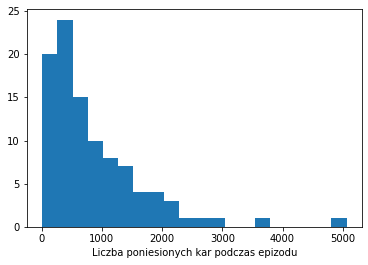

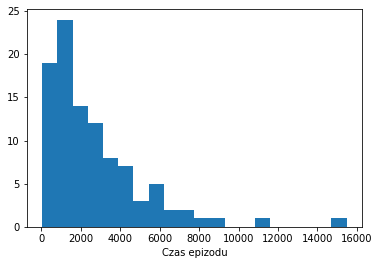

In [11]:
random_agent.evaluate(100)

In [12]:
from IPython.display import clear_output
from time import sleep

def print_episode(records: List[Dict], refresh_time: float = 0.1) -> None:
    for i, record in enumerate(records):
        clear_output(wait=True)
        print(record['frame'])
        print(f"Czas: {i + 1}")
        print(f"Stan: {record['state']}")
        print(f"Akcja: {record['action']}")
        print(f"Nagroda: {record['reward']}")
        sleep(refresh_time)
        
print_episode(records=recorded_episode, refresh_time=0.1)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Czas: 216
Stan: 0
Akcja: 5
Nagroda: 20


In [13]:
import random
from typing import List

class QLearningAgent(Agent):
    def __init__(self,
                 environment: gym.Env,
                 alpha: float = 0.1,
                 gamma: float = 0.6,
                 epsilon: float = 0.1) -> None:
        super().__init__(environment)
        # Hyperparameters
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = np.zeros([self.env.observation_space.n,
                                 self.env.action_space.n])
    
    def learn(self, epochs: int) -> List[float]:
        cumulative_rewards = []
        
        for _ in tqdm(range(epochs)):
            cumulative_reward = 0

            state = self.env.reset()

            done = False
            while not done:
                # strategia epsilon-greedy
                if random.uniform(0, 1) < self.epsilon:
                    action = self.env.action_space.sample() # Explore action space
                else:
                    action = self.act(state) # Exploit learned values

                next_state, reward, done, info = env.step(action) 

                old_q_value = self.q_table[state, action]
                next_max_q_value = np.max(self.q_table[next_state])

                new_q_value = old_q_value + self.alpha * (reward + self.gamma * next_max_q_value - old_q_value)
                self.q_table[state, action] = new_q_value

                state = next_state
                cumulative_reward += reward
            
            cumulative_rewards.append(cumulative_reward)
        return cumulative_rewards
    
    def act(self, state: int) -> int:
        return np.argmax(self.q_table[state])

In [14]:
ql_agent = QLearningAgent(env)
_ = ql_agent.learn(50000)

100%|███████████████████████████████████| 50000/50000 [00:18<00:00, 2692.26it/s]


100%|███████████████████████████████████████| 300/300 [00:00<00:00, 8116.33it/s]


Statystyki:
Średni czas epizodu: 13.08
Średnia liczba poniesionych kar podczas epizodu: 0.0


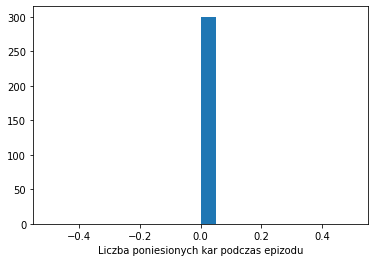

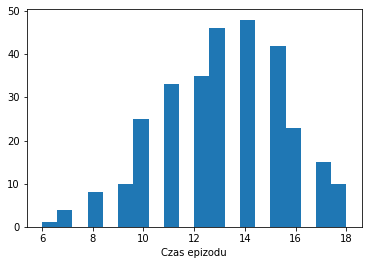

In [15]:
ql_agent.evaluate(300)

In [16]:
ql_recorded_episode = record_episode(environment=env, agent=ql_agent)
print_episode(records=ql_recorded_episode)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Czas: 11
Stan: 0
Akcja: 5
Nagroda: 20


<AxesSubplot:>

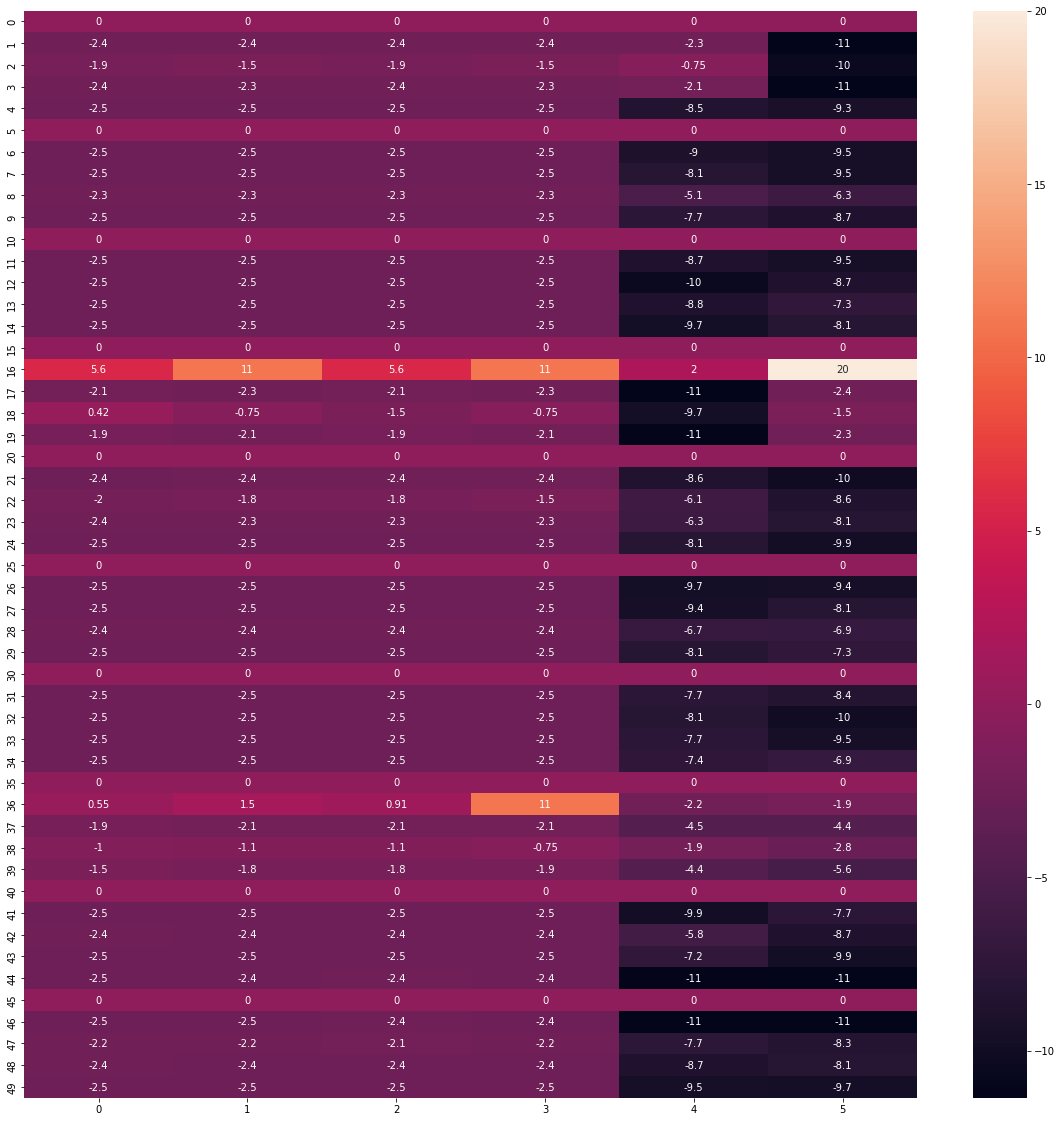

In [17]:
plt.figure(figsize=(20, 20))
sns.heatmap(ql_agent.q_table[:50], annot=True)

## Wizualizacja wartości Q na mapie

In [18]:
states = []
for i in range(500):
    states.append(list(env.decode(i)))
states = np.array(states)
states

array([[0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 2],
       ...,
       [4, 4, 4, 1],
       [4, 4, 4, 2],
       [4, 4, 4, 3]])

In [19]:
def show_q_map(passenger_loc: int, destination_loc: int) -> None:
    states_to_plot = np.where((states[:, 2] == passenger_loc) & (states[:, 3] == destination_loc))[0]
    
    q_values_map = np.zeros((5, 5))

    for state_id in states_to_plot:
        q_values_map[states[state_id, 0], states[state_id, 1]] = max(ql_agent.q_table[state_id])
        
    sns.heatmap(q_values_map, annot=True)

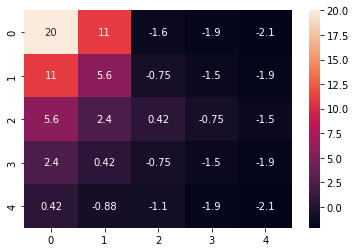

In [20]:
show_q_map(passenger_loc=4, destination_loc=0) # pasażer w taxi i zmierza do punktu R

In [21]:
env.s = 16
print(list(env.decode(16)))
env.render()

[0, 0, 4, 0]
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


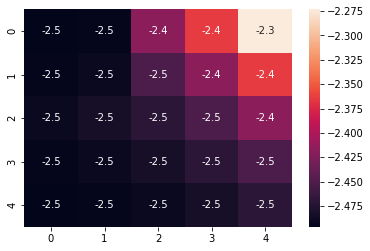

In [22]:
show_q_map(passenger_loc=1, destination_loc=0) # pasażer w punkcie G i zmierza do punktu R

In [23]:
env.s = env.encode(1, 3, 0, 1)
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


## Krzywe uczenia

Zupdatowany agent o cumulative_rewards i o pola klasy

In [24]:
ql_agent = QLearningAgent(env)
learning_curve = ql_agent.learn(10000)

100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1576.44it/s]


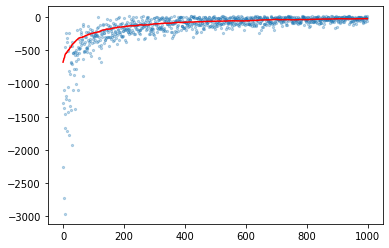

In [25]:
plt.scatter(range(1000), learning_curve[:1000], alpha=0.3, s=5)
smoothed = np.convolve(learning_curve, np.ones(100)/100, mode='valid')
plt.plot(smoothed[:1000], c='red')

## Analiza hiperparametrów

#### Współczynnika randomizacji akcji


Mały $\epsilon$ -> Szybka zbieżność, większa eksploatacja, mniej losowych akcji, duża wrażliwość na rzadko występujące stany

Duży $\epsilon$ -> Wolna zbieżność, większa eksploracja, więcej losowych akcji, mniejsza wrażliwość na rzadko występujące stany

Sensowny kompromis: zaczynać od dużego $\epsilon$ i wraz z trwaniem uczenia zmiejszać go do ustalonego minimum.

100%|████████████████████████████████████| 10000/10000 [00:18<00:00, 529.64it/s]


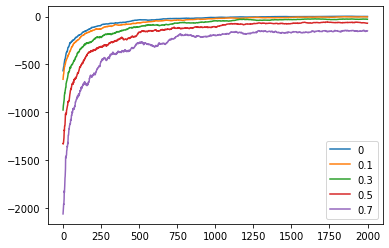

In [26]:
for eps in [0, 0.1, 0.3, 0.5, 0.7]:
    ql_agent = QLearningAgent(env,
                              epsilon=eps)
    learning_curve = ql_agent.learn(10000)
    smoothed_learning_curve = np.convolve(learning_curve, np.ones(100)/100, mode='valid')
    plt.plot(smoothed_learning_curve[:2000], label=eps)
plt.legend()

#### Analiza współczynnika dyskonta

Dla $\gamma$ >= 1 brak zbieżności

Mała gamma -> Wolna zbieżność, duży nacisk na najbliższe nagrody

Duża gamma -> Szybka zbieżność, mały nacisk na najbliższe nagrody

100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1814.63it/s]


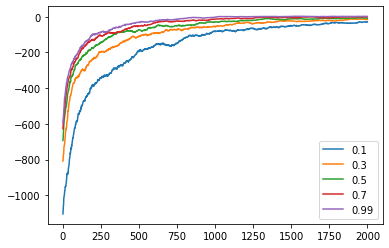

In [27]:
for gam in [0.1, 0.3, 0.5, 0.7, 0.99]:
    ql_agent = QLearningAgent(env,
                              epsilon=0.1,
                              gamma=gam)
    learning_curve = ql_agent.learn(10000)
    smoothed_learning_curve = np.convolve(learning_curve, np.ones(100)/100, mode='valid')
    plt.plot(smoothed_learning_curve[:2000], label=gam)
plt.legend()

#### Analiza współczynnika uczenia

Mała $\alpha$ -> Wolna zbieżność, ostrożniejsze updaty

Duża $\alpha$ -> Szybka zbieżność, ostrzejsze updaty, zagrożenie w przypadku złożonych środowisk niewystarczajacym rozpoznaniem otoczenia

100%|███████████████████████████████████| 10000/10000 [00:04<00:00, 2483.17it/s]


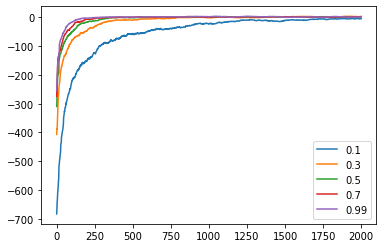

In [28]:
for alp in [0.1, 0.3, 0.5, 0.7, 0.99]:
    ql_agent = QLearningAgent(env,
                              epsilon=0.1,
                              alpha=alp)
    learning_curve = ql_agent.learn(10000)
    smoothed_learning_curve = np.convolve(learning_curve, np.ones(100)/100, mode='valid')
    plt.plot(smoothed_learning_curve[:2000], label=alp)
plt.legend()

### Przykładowa strategia epsilon-decay

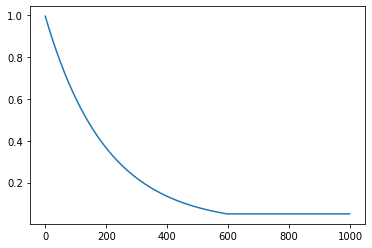

In [29]:
eps = 1
eps_decay = 0.995
eps_min = 0.05
epsilons = []

for _ in range(1000):
    eps *= eps_decay
    epsilons.append(max(eps_min, eps))
    
plt.plot(epsilons)